<!--NOTEBOOK_HEADER-->
*This notebook contains material from [PyRosetta](https://RosettaCommons.github.io/PyRosetta);
content is available [on Github](https://github.com/RosettaCommons/PyRosetta.notebooks.git).*

<!--NAVIGATION-->
< [*De Novo* Parametric Backbone Design](http://nbviewer.jupyter.org/github/RosettaCommons/PyRosetta.notebooks/blob/master/notebooks/06.06-Introduction-to-Parametric-backbone-design.ipynb) | [Contents](toc.ipynb) | [Index](index.ipynb) | [Docking](http://nbviewer.jupyter.org/github/RosettaCommons/PyRosetta.notebooks/blob/master/notebooks/07.00-Docking.ipynb) ><p><a href="https://colab.research.google.com/github/RosettaCommons/PyRosetta.notebooks/blob/master/notebooks/06.07-Introduction-to-DeNovo-protein-design.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a>

# **Point Mutation Scan between Antigen and Antibody**

The purpose of this section is to create a protocol that prepares a antibody-antigen bound structure, makes point mutation on the antibody, records change in binding enregy, and generates a heatmap demonstrating energy differences. This method is widely used in antibody interface design for either improving binding affinity or expanding the binding range. The whole protocol is broken down by eight steps.

**Step 1.** Prepare the structure with FastRelax()

**Step 2.** Write the function to perform the mutation PackMover()

**Step 3.** Write the function to unbind the antibody-antigen bound structure unbind()

**Step 4.** Write the function to get wildtype amino acid

**Step 5.** Write the function to properly mutate and pack a specific residue and output energy metrics

**Step 6.** Loop through interface positions mutating them into 20 amino acids with output files

**Step 7.** Summarize all input files for binding energy analysis



**Keywords:**

FastRelax, ResidueSelector, NeighborhoodResidueSelector, TaskFactory, TaskOperation, RestrictToRepackingRLT, RestrictAbsentCanonicalAASRLT, NoRepackDisulfides, OperateOnResidueSubset, RigidBodyTransMover, ggplot2


###**Section Contributors:**
Yuanhan Wu (The Wistar Institute)

Daniel Kulp (The Wistar Institute)

Jared Adolf-Bryfogle (Scripps; Institute for Protein Innovation)

Ajasja Ljubetič (University of Washington)

### Set up notebook

In [0]:
# Notebook setup
import sys
if 'google.colab' in sys.modules:
    !pip install pyrosettacolabsetup
    import pyrosettacolabsetup
    pyrosettacolabsetup.setup()
    print ("Notebook is set for PyRosetta use in Colab.  Have fun!")

Drive already mounted at /content/google_drive; to attempt to forcibly remount, call drive.mount("/content/google_drive", force_remount=True).
Notebook is set for PyRosetta use in Colab.  Have fun!
Mounted at /content/google_drive


**Make sure you are in the directory with the pdb files:**

`cd google_drive/My\ Drive/student-notebooks/`

### Loading structures 

In [0]:
from pyrosetta import * 
init()
pose = pose_from_pdb("inputs/1jhl.clean.pdb")
testPose = Pose()
testPose.assign(pose)
print(testPose)

PyRosetta-4 2019 [Rosetta PyRosetta4.MinSizeRel.python36.linux 2019.38+release.f3cd88e4837a35eba6d19fd9c30ebf5748c77cae 2019-09-18T23:40:11] retrieved from: http://www.pyrosetta.org
(C) Copyright Rosetta Commons Member Institutions. Created in JHU by Sergey Lyskov and PyRosetta Team.
core.init: Checking for fconfig files in pwd and ./rosetta/flags
core.init: Rosetta version: PyRosetta4.MinSizeRel.python36.linux r232 2019.38+release.f3cd88e f3cd88e4837a35eba6d19fd9c30ebf5748c77cae http://www.pyrosetta.org 2019-09-18T23:40:11
core.init: command: PyRosetta -ex1 -ex2aro -database /content/google_drive/My Drive/KulpLab/PyRosetta/prefix/pyrosetta-2019.38+release.f3cd88e-py3.6-linux-x86_64.egg/pyrosetta/database
basic.random.init_random_generator: 'RNG device' seed mode, using '/dev/urandom', seed=1053177162 seed_offset=0 real_seed=1053177162
basic.random.init_random_generator: RandomGenerator:init: Normal mode, seed=1053177162 RG_type=mt19937
core.import_pose.import_pose: File 'inputs/1jhl.c

## **Step 1. Prepare the starting structure with FastRelax()**

Properly relaxing a structure is crucial in design with Rosetta. A non relaxed structure may not overcome bad global energy well and therefore skew the following analysis on binding energy.

A FastRelax() is used to relax the structrue. While we want to put the sturcture in its lowest energy state, we want to keep the backbone information from the crystal structure as much as possible (lowest RMSD). Therefore, we apply constrain_relax_to_start_coords(True) to FastRelax().

Since FastRelax() is taking up a huge amount of resource, running it seems to crash the notebook, we commented out the "apply" part (the part that perform the relax) and print out the relaxMover() instead. We uploaded the relaxed structure to the input folder for furthre analysis.



In [0]:
from pyrosetta.rosetta.protocols.relax import FastRelax

relax = FastRelax()
scorefxn = get_fa_scorefxn()
relax.set_scorefxn(scorefxn)
relax = rosetta.protocols.relax.FastRelax()
relax.constrain_relax_to_start_coords(True)
print(relax)
#relax.apply(testPose)
#testPose.dump_pdb('test.relax.pdb')

core.scoring.ScoreFunctionFactory: SCOREFUNCTION: ref2015
core.scoring.ScoreFunctionFactory: SCOREFUNCTION: ref2015
core.scoring.ScoreFunctionFactory: SCOREFUNCTION: ref2015


### Writing Function in Python

Function is a good way to organize your code. Starting from this section I am introducing serveral functions to facilitate the protocol.

To define a function in python, a "def" key word is used. A function can either returns a value or simply executing code blocks. A defined function can be called in main function or other sections of code too.

##**Step 2. Write the function for mutation**

This function utilizes the **ResidueSelectorMover()** as demonstrated by previous tutorials. Mutated position is allowed to be designed and repacked while the neighborhood residues are limited to repacked only. The final mutation will be performed with a **PackMover()**.

In [0]:
from pyrosetta.rosetta.core.pack.task import *
from pyrosetta.rosetta.protocols import *
from pyrosetta.rosetta.core.select import *

def pack(pose, posi, amino, scorefxn):

    # Select Mutate Position
    mut_posi = pyrosetta.rosetta.core.select.residue_selector.ResidueIndexSelector()
    mut_posi.set_index(posi)
    #print(pyrosetta.rosetta.core.select.get_residues_from_subset(mut_posi.apply(pose)))

    # Select Neighbor Position
    nbr_selector = pyrosetta.rosetta.core.select.residue_selector.NeighborhoodResidueSelector()
    nbr_selector.set_focus_selector(mut_posi)
    nbr_selector.set_include_focus_in_subset(True)
    #print(pyrosetta.rosetta.core.select.get_residues_from_subset(nbr_selector.apply(pose)))

    # Select No Design Area
    not_design = pyrosetta.rosetta.core.select.residue_selector.NotResidueSelector(mut_posi)
    #print(pyrosetta.rosetta.core.select.get_residues_from_subset(not_design.apply(pose)))

    # The task factory accepts all the task operations
    tf = pyrosetta.rosetta.core.pack.task.TaskFactory()

    # These are pretty standard
    tf.push_back(pyrosetta.rosetta.core.pack.task.operation.InitializeFromCommandline())
    tf.push_back(pyrosetta.rosetta.core.pack.task.operation.IncludeCurrent())
    tf.push_back(pyrosetta.rosetta.core.pack.task.operation.NoRepackDisulfides())

    # Disable Packing
    prevent_repacking_rlt = pyrosetta.rosetta.core.pack.task.operation.PreventRepackingRLT()
    prevent_subset_repacking = pyrosetta.rosetta.core.pack.task.operation.OperateOnResidueSubset(prevent_repacking_rlt, nbr_selector, True )
    tf.push_back(prevent_subset_repacking)

    # Disable design
    tf.push_back(pyrosetta.rosetta.core.pack.task.operation.OperateOnResidueSubset(
        pyrosetta.rosetta.core.pack.task.operation.RestrictToRepackingRLT(),not_design))

    # Enable design
    aa_to_design = pyrosetta.rosetta.core.pack.task.operation.RestrictAbsentCanonicalAASRLT()
    aa_to_design.aas_to_keep(amino)
    tf.push_back(pyrosetta.rosetta.core.pack.task.operation.OperateOnResidueSubset(aa_to_design, mut_posi))
    
    # Create Packer
    packer = pyrosetta.rosetta.protocols.minimization_packing.PackRotamersMover()
    packer.task_factory(tf)

    #Perform The Move
    if not os.getenv("DEBUG"):
      packer.apply(pose)

relaxPose = pose_from_pdb("inputs/1jhl.relax.pdb")
resfile = "resfile"
scorefxn = get_fa_scorefxn()
print("\nOld Energy:", scorefxn(relaxPose),"\n")
pack(relaxPose, 130, 'A', scorefxn)
print("\nNew Energy:", scorefxn(relaxPose),"\n")
relaxPose = pose_from_pdb("inputs/1jhl.relax.pdb")


core.import_pose.import_pose: File 'inputs/1jhl.relax.pdb' automatically determined to be of type PDB
core.conformation.Conformation: Found disulfide between residues 230 351
core.conformation.Conformation: current variant for 230 CYS
core.conformation.Conformation: current variant for 351 CYS
core.conformation.Conformation: current variant for 230 CYD
core.conformation.Conformation: current variant for 351 CYD
core.conformation.Conformation: Found disulfide between residues 130 204
core.conformation.Conformation: current variant for 130 CYS
core.conformation.Conformation: current variant for 204 CYS
core.conformation.Conformation: current variant for 130 CYD
core.conformation.Conformation: current variant for 204 CYD
core.conformation.Conformation: Found disulfide between residues 23 88
core.conformation.Conformation: current variant for 23 CYS
core.conformation.Conformation: current variant for 88 CYS
core.conformation.Conformation: current variant for 23 CYD
core.conformation.Confor

### **Step 3. unbind()**
This function is for binding energy analysis. To compute a binding energy, we need to score the total energy of a bound state structure, separate (unbind) the antigen and antibody and then score the unbound state total energy. The binding energy is given by **bound energy** - **unbound energy**.

In [0]:
def unbind(pose, partners):
    STEP_SIZE = 100
    JUMP = 2
    docking.setup_foldtree(pose, partners, Vector1([-1,-1,-1]))
    trans_mover = rigid.RigidBodyTransMover(pose,JUMP)
    trans_mover.step_size(STEP_SIZE)
    trans_mover.apply(pose)

from pyrosetta.rosetta.protocols import *
scorefxn = get_fa_scorefxn()
print("\nBound State Score",scorefxn(relaxPose),"\n")
unbind(relaxPose, "HL_A")
print("\nUnbound State Score", scorefxn(relaxPose),"\n")


core.scoring.ScoreFunctionFactory: SCOREFUNCTION: ref2015

Bound State Score -1056.7705984922818 

protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.552606 0.336448 0.762515 -0.674731 0.717663 0.172329 -0.489249 -0.609723 0.623597 -24.7339 16.9267 23.6626
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.552606 0.336448 0.762515 -0.674731 0.717663 0.172329 -0.489249 -0.609723 0.623597 -100.087 26.161 88.7517

Unbound State Score -998.7221851693661 



## **Step 4. wildtype()**

An important metrics for evaluating binding improvement is the ratio of mutant binding energy to wild type binding energy. This function returns the wild type amino acids in a given position. 

In [0]:
def wildtype(aatype = 'AA.aa_gly'):
    AA = ['G','A','L','M','F','W','K','Q','E','S','P'
            ,'V','I','C','Y','H','R','N','D','T']

    AA_3 = ['AA.aa_gly','AA.aa_ala','AA.aa_leu','AA.aa_met','AA.aa_phe','AA.aa_trp'
            ,'AA.aa_lys','AA.aa_gln','AA.aa_glu', 'AA.aa_ser','AA.aa_pro','AA.aa_val'
            ,'AA.aa_ile','AA.aa_cys','AA.aa_tyr','AA.aa_his','AA.aa_arg','AA.aa_asn'
            ,'AA.aa_asp','AA.aa_thr']

    for i in range(0, len(AA_3)):
        if(aatype == AA_3[i]):
            return AA[i]

print(wildtype(str(relaxPose.aa(130))))


C


## **Step 5. Integrate functions for mutate and output**

In [0]:
def mutate(pose, posi, amino, partners):
    #main function for mutation
    CSV_PREFIX = 'notec'
    PDB_PREFIX = 'notep'

    #Initiate test pose
    testPose = Pose()
    testPose.assign(pose)

    #Initiate energy function
    scorefxn = get_fa_scorefxn()
    unbind(testPose, partners)
    native_ub = scorefxn(testPose)
    testPose.assign(pose)
    
    #Variables initiation
    content = ''
    name = CSV_PREFIX + str(posi)+str(amino) + '.csv'
    pdbname = PDB_PREFIX + str(posi)+str(amino) + '.pdb'
    wt = wildtype(str(pose.aa(posi)))

    pack(testPose, posi, amino, scorefxn)
    testPose.dump_pdb(pdbname)
    bound = scorefxn(testPose)
    unbind(testPose, partners)
    unbound = scorefxn(testPose)
    binding = unbound - bound
    testPose.assign(pose)

    if (wt == amino):
        wt_energy = binding
    else:
        pack(testPose, posi, wt, scorefxn)
        wtbound = scorefxn(testPose)
        unbind(testPose, partners)
        wtunbound = scorefxn(testPose)
        wt_energy = wtunbound - wtbound
        testPose.assign(pose)

    content=(content+str(pose.pdb_info().pose2pdb(posi))+','+str(amino)+','
              +str(native_ub)+','+str(bound)+','+str(unbound)+','+str(binding)+','
              +str(wt_energy)+','+str(wt)+','+str(binding/wt_energy)+'\n')

    f = open(name,'w+')
    f.write(content)
    f.close()

mutate(relaxPose, 130, 'A', 'HL_A')


core.scoring.ScoreFunctionFactory: SCOREFUNCTION: ref2015
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.552606 0.336448 0.762515 -0.674731 0.717663 0.172329 -0.489249 -0.609723 0.623597 -100.087 26.161 88.7517
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.552606 0.336448 0.762515 -0.674731 0.717663 0.172329 -0.489249 -0.609723 0.623597 -175.441 35.3952 153.841
protocols.minimization_packing.PackRotamersMover: [ WARNING ] undefined ScoreFunction -- creating a default one
core.scoring.ScoreFunctionFactory: SCOREFUNCTION: ref2015
core.pack.task: Packer task: initialize from command line()
core.pack.pack_rotamers: built 858 rotamers at 23 positions.
core.pack.interaction_graph.interaction_graph_factory: Instantiating DensePDInteractionGraph
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.552606 0.336448 0.762515 -0.674731 0.717663 0.172329 -0.489249 -0.609723 0.623597 -100.087 26.161 88.7517
protocols.moves.RigidBodyMover: Translate: Jump (a

## **Step 6. Loop through interface positions**

The following code loop through all heavy chain and light chain positions mutating them into all 20 amino acids. The actual run may again crash the notebook. In my work, i simply output energy information of each mutation in form of csv files and cat them into one file for future analysis. An output file is uploaded to the input folder for the R analysis. In real work setting, parallelization can be achieve by submitting multiple jobs (for loop, each loop will be run on one CPU) in a shell script. For this task, you not necessarily need to finish the whole loop. We had a finished version in the inputs folder.


In [0]:
import os
os.chdir("./outputs")
os.mkdir("NNK_outputs")
os.chdir("./NNK_outputs")
os. getcwd()

if not os.getenv("DEBUG"):
  for i in [92,85,68,53,5,45,44,42,32,31,22,108,100]:
    print("\nMutating Position: ",str(i),"\n")
    for j in ['G','A','L','M','F','W','K','Q','E','S','P','V','I','C','Y','H','R','N','D','T']:
      mutate(relaxPose, i, j, 'HL_A')


Mutating Position:  92 

core.scoring.ScoreFunctionFactory: SCOREFUNCTION: ref2015
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.552606 0.336448 0.762515 -0.674731 0.717663 0.172329 -0.489249 -0.609723 0.623597 -100.087 26.161 88.7517
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.552606 0.336448 0.762515 -0.674731 0.717663 0.172329 -0.489249 -0.609723 0.623597 -175.441 35.3952 153.841
protocols.minimization_packing.PackRotamersMover: [ WARNING ] undefined ScoreFunction -- creating a default one
core.scoring.ScoreFunctionFactory: SCOREFUNCTION: ref2015
core.pack.task: Packer task: initialize from command line()
core.pack.pack_rotamers: built 492 rotamers at 17 positions.
core.pack.interaction_graph.interaction_graph_factory: Instantiating PDInteractionGraph
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.552606 0.336448 0.762515 -0.674731 0.717663 0.172329 -0.489249 -0.609723 0.623597 -100.087 26.161 88.7517
protocols.moves.RigidBodyMove

Merging output csv files for binding energy analysis in R

In [0]:
import os
!cat *csv > test_output.csv
cmd = "scp test_output.csv \"/PATH/TO/notebooks/inputs\""
# Ex. "scp test_output.csv \"/google_drive/My\ Drive/student-notebooks/inputs\""
os.system(cmd)

0

##**Analysis of binding data**
After gathering summarized binding energy information, we use pandas for filtering and visualization. We filtered out lower unbound energy structures, those that have higher unbound state total energy than native and make a heatmap from the filtered data. In case you don't want to finish the for loop at Step 8, we uploaded a finished version of merged output csv to the inputs folder named "note_output.csv".

In [0]:
#import modules need for analysis
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt 
import seaborn as sns

In [0]:
os.chdir("/PATH/TO/notebooks/inputs")
csv_file_name = 'note_output.csv' #Change to test_output.csv
df = df.fillna(0.0)
df.head(5)

Amino.Acid,A,C,D,E,F,G,H,I,K,L,M,N,Q,R,S,T,V,W,Y
Position_WT_aa,,,,,,,,,,,,,,,,,,,
100 L (G),0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.105448,0.000000,0.000000,0.000000,0.000000,1.175747,0.000000,0.000000,0.000000,1.105448,0.000000
108 L (R),0.000000,0.000000,1.072642,1.071698,0.000000,1.071698,1.071698,0.000000,1.073585,0.000000,0.000000,1.071698,0.000000,0.000000,0.000000,0.000000,1.071698,1.073585,0.000000
22 L (N),1.015094,0.000000,0.000000,1.073585,0.000000,0.000000,0.000000,0.000000,1.073585,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
31 L (K),1.015094,0.000000,1.016038,1.015094,0.000000,1.015094,0.000000,0.000000,0.000000,1.015094,1.089623,1.015094,0.000000,1.074528,1.090566,0.000000,0.000000,0.000000,0.000000
32 L (S),1.039216,1.039216,1.116667,1.039216,1.039216,1.115686,1.039216,1.115686,0.000000,1.039216,0.000000,1.115686,1.115686,1.114706,0.000000,1.115686,1.039216,1.115686,1.115686


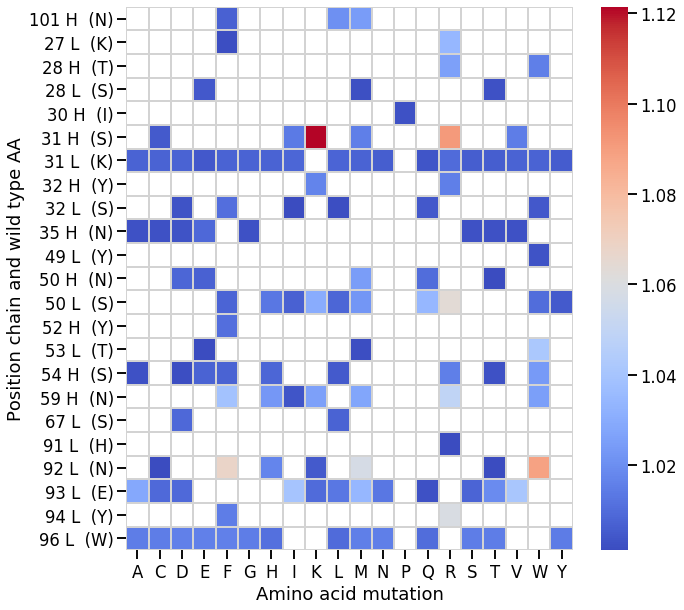

In [0]:
#Generating heatmaps

UNBOUND_CUTOFF = -995
RATIO_CUTOFF = 1.001

#load the data into a pandas dataframe
df = pd.read_csv(csv_file_name, names='Position Amino.Acid Native Bound Unbound Binding WT_Binding WT Ratio'.split(), index_col=False )
#Add wildtype AA to position (for display)
df['Position_WT_aa'] = df.Position + ' (' + df.WT  + ')' 

#filter values
df = df.query(f'Unbound<{UNBOUND_CUTOFF} and Ratio>{RATIO_CUTOFF}')

# convert from tidy format (https://en.wikipedia.org/wiki/Tidy_data) to a wider format
df = pd.pivot_table(df, values='Ratio', 
                     index=['Position_WT_aa'], 
                     columns='Amino.Acid')

#plot the heatmap
f, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(df, cmap='coolwarm', linewidths= 1, linecolor='lightgray')
plt.xlabel('Amino acid mutation');
plt.ylabel('Position chain and wild type AA');
sns.set_context("talk") #make labels bigger

# See Also

Note these may not be available in PyRosetta through code or even by xml (remodel), but they are extremely useful tools when doing denovo protein design - and you should be aware of them.

- **RosettaRemodel**
 - https://www.rosettacommons.org/docs/latest/application_documentation/design/rosettaremodel
    
    
- **Sewing**

 - https://www.rosettacommons.org/docs/latest/scripting_documentation/RosettaScripts/composite_protocols/sewing/SEWING
 
 
-  **Parametric Design**
 - Previous Workshop!

<!--NAVIGATION-->
< [*De Novo* Parametric Backbone Design](http://nbviewer.jupyter.org/github/RosettaCommons/PyRosetta.notebooks/blob/master/notebooks/06.06-Introduction-to-Parametric-backbone-design.ipynb) | [Contents](toc.ipynb) | [Index](index.ipynb) | [Docking](http://nbviewer.jupyter.org/github/RosettaCommons/PyRosetta.notebooks/blob/master/notebooks/07.00-Docking.ipynb) ><p><a href="https://colab.research.google.com/github/RosettaCommons/PyRosetta.notebooks/blob/master/notebooks/06.07-Introduction-to-DeNovo-protein-design.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a>